## Обзор данных  и предобработка данных.

У нас есть открытые данные о заведениях общественного питания в Москве. Загрузим их в таблицу.

In [1]:
# импорт библиотек для работы
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import sys
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from io import BytesIO
import requests

In [2]:
# открываем файл с данными
df = pd.read_csv('..../rest_data.csv')

# выводим 5 строк для ознакомления
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [3]:
# описание данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Таблица хранит данные о заведениях общественного питания в Москве (6 столбцов и 15366 строк, типы данных по столбцам: int64(2), object(4)):

* `id` — идентификатор объекта;
* `object_name` — название объекта общественного питания;
* `chain` — сетевое ли заведение (да/нет);
* `object_type` — тип объекта общественного питания;
* `address` — адрес заведения;
* `number` — количество посадочных мест.


<div style="border:solid green 1px; padding: 10px">

Пропусков в данных нет. Названия столбцов в одном стиле и регистре. Типы данных соответствуют содержанию.
В столбце `address` где-то указано "город москва", где-то нет, т.к. данные у нас только по Москве, то можно это словосочетание убрать везде.

Также приведем значения столбцов `object_name` и `address` к одному регистру и проверим на дубликаты.

In [4]:
# приведение значений в котегориальных столбцах к общему регистру для проверки на дубликаты
check_list = ['object_name', 'address']
for col in df:
    if col in check_list:
        df[col] = df[col].str.lower()

In [5]:
#удалям "город москва"
df['address'] = df['address'].replace('город москва, ', '', regex=True)

In [6]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"улица егора абакумова, дом 9",48
1,77874,родник,нет,кафе,"улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"абрамцевская улица, дом 9, корпус 1",50


In [7]:
# проверка на дубликаты
df.duplicated().sum()

0

In [8]:
# проверка на не явные дубли (все одинаковое, кроме id)
(df.groupby(['object_name', 'object_type', 'address'])
 .agg({'object_name' : 'nunique', 'object_type' : 'nunique', 'address' : 'nunique'})
 .query('object_name > 1 and object_type > 1 and address > 1'))

,,,object_name,object_type,address
object_name,object_type,address,,,


Скорее не характерно, чем наоборот, отсутствие посадочных мест либо всего одно такое место для большинства видов заведений общественного питани.

Если судить по Московским городским строительным нормам, оптимальное количество посадочных мест для заведений общественного питания составляет:

* Ресторан - 50-200 человек;
* Бар - 25-100 человек;
* Кафе - 25-200 человек;
* Столовая - 25-200 человек;
* Закусочная - 25-50 человек;
* Кафетерий - 8-50  человек.

Однако и без посадочных мест заведения возможны, легко представить себе отдел кулинарии магазина или буфет, предусматривающий только времяпрепровождение стоя.

Посмотрим сколько в нашем датафрейме таких заведений (с числом мест не более 5ти или с числом мест от 300 и выше).

In [9]:
# заведения с числом мест не более пяти или с числом мест от 300 и выше
df.query('number <= 5 or number >=300')['object_type'].value_counts()

предприятие быстрого обслуживания    972
кафе                                 600
закусочная                           242
кафетерий                            194
магазин (отдел кулинарии)            192
столовая                             149
ресторан                             129
буфет                                 90
бар                                   68
Name: object_type, dtype: int64

In [10]:
# доля не типичных заведений
type_rest = ['предприятие быстрого обслуживания', 'закусочная', 'магазин (отдел кулинарии)',
             'кафетерий', 'кафе','ресторан', 'буфет', 'столовая', 'бар']
nottypical_rest = df.query('number <= 5 or number >=300')

for rest in type_rest:
    (print('Доля {}: '.format(rest), round((nottypical_rest.query('object_type == @rest')['id'].count()
                                            / df.shape[0] * 100), 2)))        

Доля предприятие быстрого обслуживания:  6.33
Доля закусочная:  1.57
Доля магазин (отдел кулинарии):  1.25
Доля кафетерий:  1.26
Доля кафе:  3.9
Доля ресторан:  0.84
Доля буфет:  0.59
Доля столовая:  0.97
Доля бар:  0.44


Доля, занимаемая такими заведениями от общих данных в датафрейме очень мала и их можно удалить.

Оставим только отделы кулинарии, буфеты, закусочные без "сидячих" мест, т.к. в таких заведениях довольно логично отсутсвие посадочных мест.

In [11]:
# удалим кафе, рестораны и закусочные без посадочных мест или с одним местом
type_rest_min = ['предприятие быстрого обслуживания', 'кафетерий', 'кафе','ресторан','столовая', 'бар']
df = df.drop(df.query('number <= 5 and object_type in @type_rest_min or number >=300 and object_type in @type_rest').index)

Посмотрим на сетевые объекты, есть ли такие в которые входит всего одно заведение:

In [12]:
print('Количество: ', df.query('chain == "да"').groupby('object_name').agg({'id': 'count'}).query('id == 1').shape[0])
(print('Доля: ', df.query('chain == "да"').groupby('object_name').agg({'id': 'count'}).query('id == 1').shape[0]
       / df.shape[0] * 100))

Количество:  316
Доля:  2.384725681080673


316 значений в наших данных. Возможно предположить, что признак "сетевитости" указан не верно.

Можно изменить значения столбца `chain` для этих 316 заведения с "да" на "нет", однако не для всех заведений это может быть верно, т.к. кто-то относиться по факту к сети, но из-за не верного заполнения столбца `object_name` не попадает в общую сеть, к примеру такие названия как "kfc волгоградский" или "пбо «kfc»", "prime star прайм стар" или "prime прайм стар прайм-кафе", "starbucks coffee" или "starbucks старбакс" дают возможность отнести их к одной сети.

Доля таких заведений всего 2% от общего датафрейма, удалим их вовсе.

In [13]:
#собираем и удаляем значения
chain_df = df.query('chain == "да"').groupby('object_name').agg({'id': 'count'}).query('id == 1').reset_index()
chain_df = chain_df['object_name']
chain_df
df = df.drop(df.query('object_name in @chain_df').index)

## Предварительный анализ.

### Соотношение видов объектов общественного питания по количеству.

In [14]:
# сводим данные
cnt_types = (
    df.pivot_table(index='object_type', values='id', aggfunc='count').reset_index().sort_values(by='id', ascending=False))

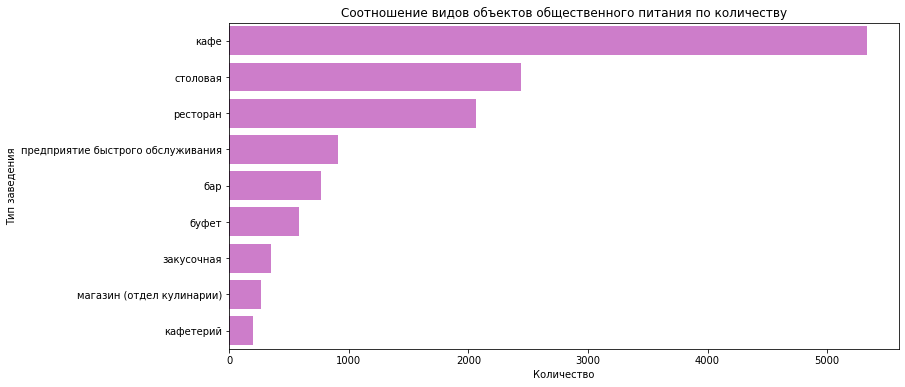

In [15]:
# строим график
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='id', y='object_type', data=cnt_types, color='orchid')
ax.set_title('Соотношение видов объектов общественного питания по количеству')
ax.set_xlabel('Количество') 
ax.set_ylabel('Тип заведения');

<div style="border:solid green 1px; padding: 10px">

Распределение заведений по типам:

1. Кафе	- 5333
2. Столовая - 2438
3. Ресторан - 2068
4. Предприятие быстрого обслуживания - 914
5. Бар - 769
6. Буфет - 582
7. Кафетерий - 348
8. Закусочная - 264
9. Магазин (отдел кулинарии) - 198

### Соотношение сетевых и несетевых заведений по количеству.

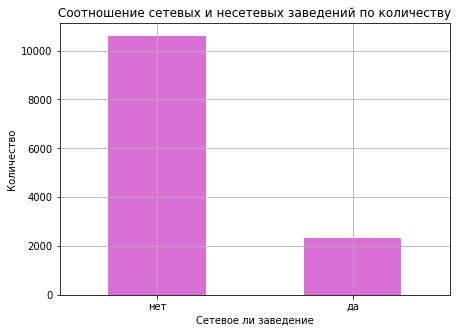

In [16]:
# строим график
plt.figure(figsize=(7, 5))
df['chain'].value_counts().plot(kind='bar', grid=True, color='orchid')
plt.xticks(rotation =0)
plt.xlabel('Сетевое ли заведение')
plt.ylabel('Количество')
plt.title('Соотношение сетевых и несетевых заведений по количеству');

In [17]:
round(df.query('chain == "да"')['id'].count() / df['id'].count(), 2)

0.18

<div style="border:solid green 1px; padding: 10px">

Не сетевиков значительно больше (12914), чем сетевых заведений (2311). Доля сетевых заведений всего 18%.

**Посмотрим для какого вида объекта общественного питания характерно сетевое распространение:**

In [18]:
# сводим данные
chain_type= (
    df.query('chain == "да"').pivot_table(index='object_type', values='chain', aggfunc='count')
    .reset_index())
# добавим солбец с долей сетевых заведений в этом сегменте
share = []
for i in range(len(chain_type)):
    rest = chain_type['object_type'][i]
    share.append(round(df.query('object_type == @rest and chain == "да"')['id'].count()/
                 df.query('object_type == @rest')['id'].count()*100, 2))

chain_type['share'] = share
chain_type = chain_type.sort_values(by='share', ascending=False)
chain_type

,object_type,chain,share
6,предприятие быстрого обслуживания,578,63.24
5,магазин (отдел кулинарии),69,26.14
3,кафе,1144,21.45
7,ресторан,423,20.45
2,закусочная,44,12.64
4,кафетерий,23,11.62
0,бар,16,2.08
1,буфет,11,1.89
8,столовая,3,0.12


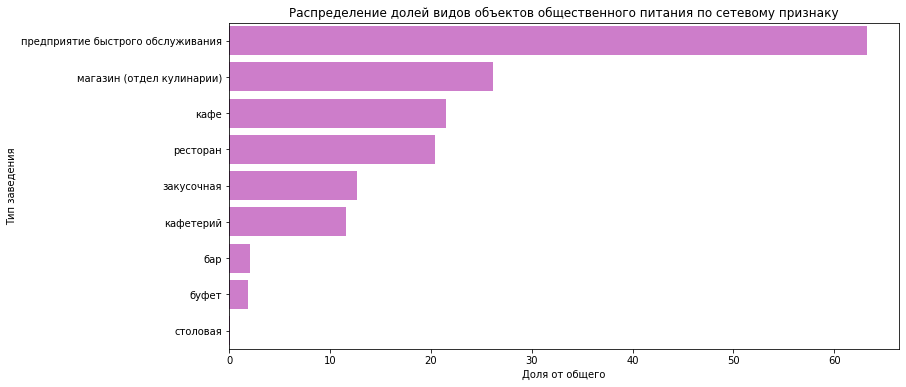

In [19]:
# строим график
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='share', y='object_type', data=chain_type, color='orchid')
ax.set_title('Распределение долей видов объектов общественного питания по сетевому признаку')
ax.set_xlabel('Доля от общего') 
ax.set_ylabel('Тип заведения');

<div style="border:solid green 1px; padding: 10px">

Распределение заведений по количеству в каждом сегменте:

1. Кафе	- 1144
2. Предприятие быстрого обслуживания - 578
3. Ресторан - 423
4. Магазин (отдел кулинарии) - 69
5. Закусочная - 44
6. Кафетерий - 23
7. Бар - 16
8. Буфет - 11
9. Столовая - 3
        
Однако относительно долей от общего количества заведений каждого вида распределение сильно меняется и становится видно, что в каких-то типах заведений сетевики составляют значительную долю (например, `Предприятие быстрого обслуживания` или `Магазин (отдел кулинарии)`), а в каки- то нет (`Буфет` или `Столовая`).

**Посмотрим что характерно для сетевых заведений относительно посадочных мест:**

Узнаем минимальное, среднее, максимальное количество посадочных мест и распределим заведения на три категории:
- `малое`
- `среднее`
- `крупное`

In [20]:
df.query('chain == "да"')['number'].describe()

count    2311.000000
mean       55.539161
std        47.633050
min         0.000000
25%        20.000000
50%        43.000000
75%        80.000000
max       284.000000
Name: number, dtype: float64

Отнесем к малым всех, у кого мест не больше 40, к средним тех, у кого до 100 мест и к крупным тех, у кого больше 100 мест в заведении.

In [21]:
def rest_category(number):
    if number <= 40:
        return 'малое'
    if number <= 100:
        return 'среднее'
    return 'крупное'

df['rest_category'] = df['number'].apply(rest_category)    

In [22]:
df['rest_category'].value_counts()

малое      6290
среднее    4531
крупное    2093
Name: rest_category, dtype: int64

In [23]:
# сводим данные
chain_rest = (
    df.query('chain == "да"').groupby(['object_type', 'rest_category']).agg({'id' : 'count'})
    .reset_index().sort_values(by=['object_type','id'], ascending=False)
)
chain_rest

,object_type,rest_category,id
20,столовая,крупное,2
21,столовая,среднее,1
19,ресторан,среднее,218
17,ресторан,крупное,133
18,ресторан,малое,72
15,предприятие быстрого обслуживания,малое,321
16,предприятие быстрого обслуживания,среднее,205
14,предприятие быстрого обслуживания,крупное,52
12,магазин (отдел кулинарии),малое,66
13,магазин (отдел кулинарии),среднее,3


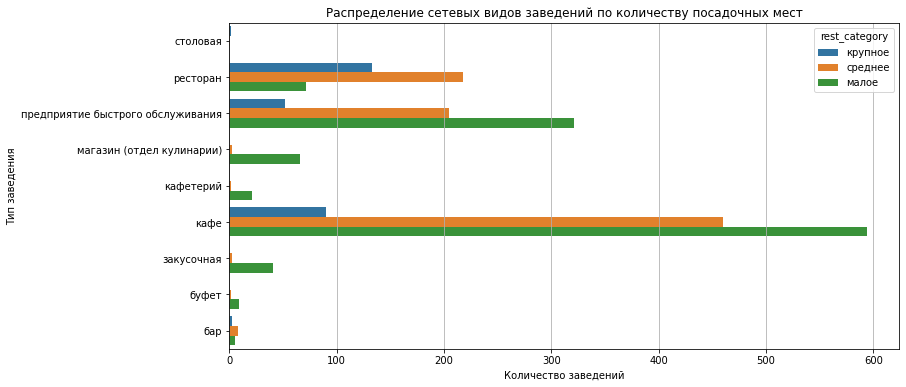

In [24]:
# строим график
plt.figure(figsize=(12, 6))
plt.grid()
ax = sns.barplot(x='id', y='object_type', hue='rest_category', data=chain_rest)
ax.set_title('Распределение сетевых видов заведений по количеству посадочных мест')
ax.set_xlabel('Количество заведений') 
ax.set_ylabel('Тип заведения');

Посмотрим на данные через другой тип графика - диаграмму рассеивания:

In [25]:
# сводим данные
chain_rest_v2 = (
    df.query('chain == "да"').groupby('object_type').agg({'number' : 'mean'}).round(2)
    .reset_index()
)
chain_rest_v2.sort_values(by='number', ascending=False)

,object_type,number
8,столовая,112.33
7,ресторан,93.44
0,бар,71.06
3,кафе,49.97
6,предприятие быстрого обслуживания,48.99
4,кафетерий,20.83
2,закусочная,15.14
1,буфет,12.73
5,магазин (отдел кулинарии),8.49


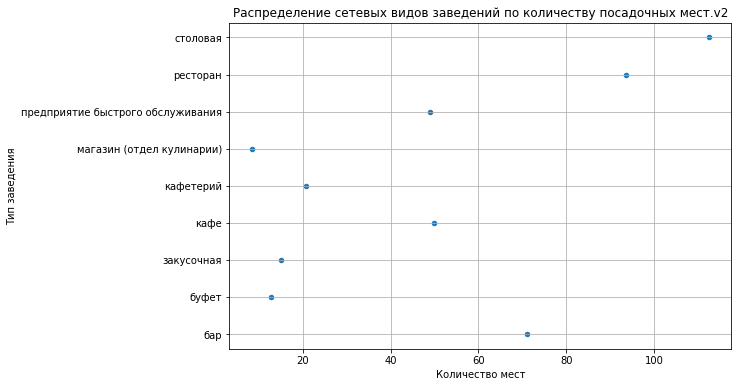

In [26]:
chain_rest_v2.plot(kind='scatter', x='number', y='object_type', grid = True, figsize=(9, 6))
plt.title('Распределение сетевых видов заведений по количеству посадочных мест.v2')
plt.ylabel('Тип заведения')
plt.xlabel('Количество мест');

<div style="border:solid green 1px; padding: 10px">

Много заведений с небольшим числом посадочных мест в каждом среди 6 видов заведений из 9 (кафе, предприятия быстрого питания, кафетерии, закусочные, буфеты, отделы кулинарии магазинов).

Рестораны в большей части средней вместительности, но и крупных сетевиков среди них тоже достаточно.

Бары средние по количеству мест в заведениях, а малых чуть меньше, крупных почти нет.

Столовые вообще редкость среди сетевых заведений, их всего 3 штуки (2 крупных и одно среднее).

### Соотношение видов объектов общественного питания по количеству посадочных мест.

Для каждого вида объекта общественного питания посмотрим какое среднее количество посадочных мест:

In [27]:
# сводим данные
seat_rest = (
    df.groupby('object_type').agg({'number': 'median'}).sort_values(by='number', ascending=False).reset_index())   
seat_rest

,object_type,number
0,столовая,100
1,ресторан,80
2,бар,36
3,кафе,36
4,буфет,32
5,предприятие быстрого обслуживания,25
6,кафетерий,10
7,закусочная,0
8,магазин (отдел кулинарии),0


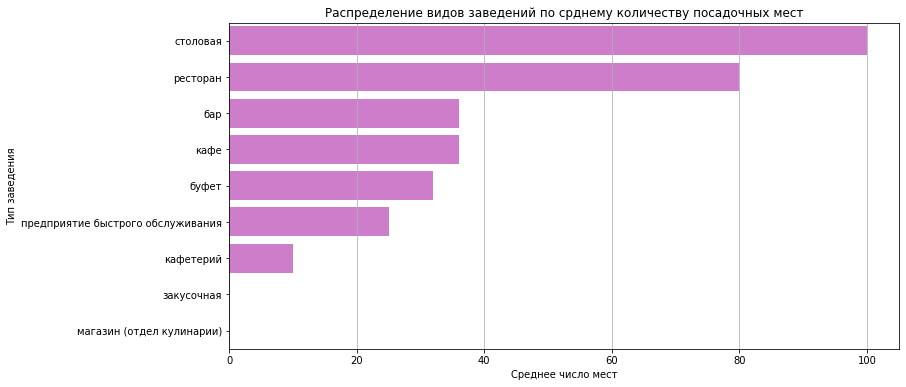

In [28]:
# строим график
plt.figure(figsize=(12, 6))
plt.grid()
ax = sns.barplot(x='number', y='object_type', data=seat_rest, color='orchid')
ax.set_title('Распределение видов заведений по срднему количеству посадочных мест')
ax.set_xlabel('Среднее число мест') 
ax.set_ylabel('Тип заведения');

<div style="border:solid green 1px; padding: 10px">

Среди всех заведений лидируют столовые по среднему числу мест в них, затем ресторaны и на третьем месте бары. В отделах кулинарии магазинов и закусочных с местами хуже всего - в среднем их там нет.

### Распределение видов объектов общественного питания по территориальному признаку.

Выделим в отдельный столбец `street` информацию об улице из столбца `address` нашей тадлицы.

In [29]:
df.insert(5, 'street', df['address'].str.extract('(.*?),'))

In [30]:
df.head()

,id,object_name,chain,object_type,address,street,number,rest_category
0,151635,сметана,нет,кафе,"улица егора абакумова, дом 9",улица егора абакумова,48,среднее
1,77874,родник,нет,кафе,"улица талалихина, дом 2/1, корпус 1",улица талалихина,35,малое
2,24309,кафе «академия»,нет,кафе,"абельмановская улица, дом 6",абельмановская улица,95,среднее
3,21894,пиццетория,да,кафе,"абрамцевская улица, дом 1",абрамцевская улица,40,малое
4,119365,кафе «вишневая метель»,нет,кафе,"абрамцевская улица, дом 9, корпус 1",абрамцевская улица,50,среднее


**Построим график топ-10 улиц по количеству объектов общественного питания на них:**

In [31]:
# сводим данные
top_streets = df.groupby('street').agg({'id': 'count'}).reset_index().sort_values(by='id', ascending=False).head(10)
top_streets

,street,id
472,город зеленоград,211
1053,проспект мира,194
685,ленинградский проспект,149
1057,профсоюзная улица,134
1016,пресненская набережная,131
688,ленинский проспект,124
408,варшавское шоссе,119
1005,поселение сосенское,113
1050,проспект вернадского,102
676,кутузовский проспект,97


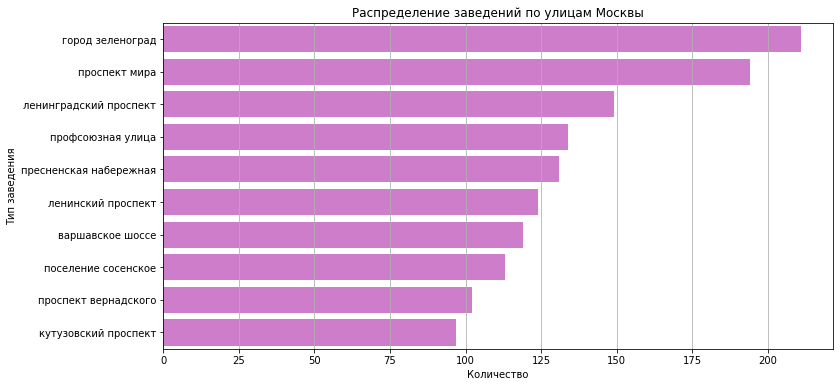

In [32]:
# строим график
plt.figure(figsize=(12, 6))
plt.grid()
ax = sns.barplot(x='id', y='street', data=top_streets, color='orchid')
ax.set_title('Распределение заведений по улицам Москвы')
ax.set_xlabel('Количество') 
ax.set_ylabel('Тип заведения');

Загрузим таблицу с данными об улицах с разбивкой по районам и округам, скачанную из интернета, для того чтобы узнать в каких районах Москвы находятся наши ТОП-10 улиц.

In [33]:
# загрузим таблицу с данными об улицах
spreadsheet_id = '1gDq19E6zG4vHwcWHbZm69UAjIijt2wmP129sj75nRp4'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
streets_df = pd.read_csv(BytesIO(r.content))

In [34]:
# приведем названия улиц к нижнему регистру
streets_df['streetname'] = streets_df['streetname'].str.lower()
streets_df.head(1)

,streetname,areaid,okrug,area
0,выставочный переулок,17,ЦАО,Пресненский район


In [35]:
# смотрим районы и округа для наших улиц
street_list = list(top_streets['street'])
streetname = []
area = []
okrug = []

for i in range(len(streets_df)):
    if streets_df['streetname'][i] in street_list:
        streetname.append(streets_df['streetname'][i])
        area.append(streets_df['area'][i])
        okrug.append(streets_df['okrug'][i])
        
columns = ['streetname', 'area', 'okrug'] 
streets_top = pd.DataFrame(columns=columns) 
streets_top['streetname'] = streetname
streets_top['area'] = area
streets_top['okrug'] = okrug
streets_top.sort_values(by='streetname', ascending=False)

,streetname,area,okrug
32,профсоюзная улица,Район Ясенево,ЮЗАО
29,профсоюзная улица,Район Черемушки,ЮЗАО
40,профсоюзная улица,Район Теплый Стан,ЮЗАО
37,профсоюзная улица,Обручевский район,ЮЗАО
33,профсоюзная улица,Район Коньково,ЮЗАО
28,профсоюзная улица,Академический район,ЮЗАО
16,проспект мира,Ярославский Район,СВАО
15,проспект мира,Алексеевский район,СВАО
19,проспект мира,Район Ростокино,СВАО
20,проспект мира,Район Свиблово,СВАО


<div style="border:solid green 1px; padding: 10px">

Больше всего заведений:
    
* в г. Зеленограде Зеленоградского административного округа (211 шт.), районы округа:
    - Панфиловский,
    - Матушкино-Савелки,
    - Крюково

* далее Проспект мира Центрального административного округа/Северо-Восточного административного округа (194 шт.), районы:
    - Ярославский,
    - Алексеевский,
    - Ростокино,
    - Свиблово,
    - Мещанский,
    - Останкинский,
    - Марьина роща
    
* и третье место у Ленинградского проспекта Северного административного округа (149 шт.), районы:
    - Аэропорт,
    - Хорошевский,
    - Сокол,
    - Беговой
    
Далее следуют остальные районы с небольшими различиями.

**Посмотрим на "обратные" улицы, т.е. с одним объектом общественного питания:**

In [36]:
# сводим данные
bottom_streets = df.groupby('street').agg({'id': 'count'}).reset_index().sort_values(by='id').query('id == 1')
print('Число улиц с одним объектом общественного питания:', bottom_streets['street'].count())

Число улиц с одним объектом общественного питания: 562


In [37]:
# смотрим районы и округа для наших улиц
street_list = list(bottom_streets['street'])
streetname = []
area = []
okrug = []

for i in range(len(streets_df)):
    if streets_df['streetname'][i] in street_list:
        streetname.append(streets_df['streetname'][i])
        area.append(streets_df['area'][i])
        okrug.append(streets_df['okrug'][i])
        
columns = ['streetname', 'area', 'okrug'] 
streets_bottom = pd.DataFrame(columns=columns) 
streets_bottom['streetname'] = streetname
streets_bottom['area'] = area
streets_bottom['okrug'] = okrug

streets_bottom['okrug'].value_counts()

ЦАО           190
ВАО            78
СВАО           69
САО            60
ЮВАО           55
ЗАО            43
СЗАО           30
ЮЗАО           29
ЮАО            29
Зеленоград      2
Name: okrug, dtype: int64

<div style="border:solid green 1px; padding: 10px">

Всего нашлось 562 улицы с одним объектом общественного питания на них.

Большое скопление улиц с одним заведением на них в Центральном административном округе (190 улиц), что может быть связано с большим количеством маленьких по своей протяженности улиц, переулков, тупиков и пр. в этом районе. Также много улиц с одиночными заведениями на них в Восточном (78 улиц) и Северо-Восточном административных округах (69 улиц), да и в целом севернее Центрального округа таких улиц больше, чем южнее Центрального округа.

## Выводы

<div style="border:solid green 2px; padding: 20px">

Нам были доступны открытые данные о заведениях общественного питания в Москве, содержащие информацию о наименованиях, видах, адресах заведений и количестве посадочных мест в них.
    
Мы изучили данные и выявили, что:
    
1.	По виду заведения распределены так:
* преобладают `Кафе` - 5333
* далее `Столовая` - 2438
* затем `Ресторан` - 2068
* и следом:
    - `Предприятие быстрого обслуживания` - 914
    - `Бар` - 769
    - `Буфет` - 582
    - `Кафетерий` - 348
    - `Закусочная` - 264
    - `Магазин (отдел кулинарии)` – 198
    
2.	Не сетевиков значительно больше (12914), чем сетевых заведений (2311).
    
Доля сетевых заведений всего 18% и их виды распределились так:
* `Кафе` - 1144
* `Предприятие быстрого обслуживания` - 578
* `Ресторан` - 423
* `Магазин (отдел кулинарии)` - 69
* `Закусочная` - 44
* `Кафетерий` - 23
* `Бар` - 16
* `Буфет` - 11
* `Столовая` – 3
    
Однако относительно долей от общего количества заведений каждого вида распределение сильно меняется и становится видно, что в каких-то типах заведений сетевики составляют значительную долю (например, `Предприятие быстрого обслуживания` (63.24%) или `Магазин (отдел кулинарии)`(26.14%)), а в каки- то нет (например, `Буфет` (1.89%) или `Столовая`(0.12%)).
    
Среди сетевиков:
* много заведений с небольшим числом посадочных мест в каждом (до 40 мест), целых 6 видов заведений из 9 (`кафе`, `предприятия быстрого питания`, `кафетерии`, `закусочные`, `буфеты`, `отделы кулинарии магазинов`).
* `рестораны` в большей части средней вместительности, но и крупных сетевиков среди них тоже достаточно.
* `бары` средние по количеству мест в заведениях, чуть меньше, крупных почти нет.
* `Столовые` вообще редкость среди сетевых заведений, их всего 3 штуки (2 крупных и одно среднее).
    
3.	Среди всех заведений (без привязки в признаку сетевика) лидируют `столовые` по среднему числу мест в них, затем `ресторaны` и на третьем месте `бары`. В `отделах кулинарии магазинов` и `закусочных` с местами хуже всего.
    
4.	Больше всего заведений:
* в г. Зеленограде Зеленоградского административного округа (211 шт.), районы округа:
    - Панфиловский,
    - Матушкино-Савелки,
    - Крюково
* далее Проспект мира Центрального административного округа/Северо-Восточного административного округа (194 шт.), районы:
    - Ярославский,
    - Алексеевский,
    - Ростокино,
    - Свиблово,
    - Мещанский,
    - Останкинский,
    - Марьина роща
* и третье место у Ленинградского проспекта Северного административного округа (149 шт.), районы:
    - Аэропорт,
    - Хорошевский,
    - Сокол,
    - Беговой
    
Далее следуют остальные районы с небольшими различиями.

5.	Всего нашлось 562 улицы с одним объектом общественного питания на них.
    
Большое скопление улиц с одним заведением на них в Центральном административном округе (190 улиц), что может быть связано с большим количеством маленьких по своей протяженности улиц, переулков, тупиков и пр. в этом районе. Также много улиц с одиночными заведениями на них в Восточном (78 улиц) и Северо-Восточном административных округах (69 улиц), да и в целом севернее Центрального округа таких улиц больше, чем южнее Центрального округа.
    
    
Итак, стоит обратить внимание, что `кафетериев` и `закусочных` не так и много в Москве, маленькое заведение вмещает, в среднем, около 17 мест, самые малонаселенные заведениями улицы: Кутузовский проспект и Проспект Вернадского в Западном административном округе, а также Сосенское — поселение в Новомосковском округе столицы.
    
Также есть возможность развития в сеть, т.к. сетевых заведений значительно меньше в Москве.

## Презентация.
Мы подготовили [презентацию](https://disk.yandex.ru/d/7sCX4c32iU6_HQ) для инвесторов с исследованием рынка заведений общественного питания в Москве.